# Classifiers Applied to Health Sector Data

In this notebook, we get data from `historical_stock_prices.csv` (Kaggle) and extract the health sector. After some preprocessing, we apply various classifiers to see if any models can detect DST vs non-DST weekends. The classifiers used are logistic regression, $k$ nearest neighbors, decision tree, random forest, extra tree and the balanced versions of these last three. There was not much success in classification which supports the null hypothesis.

Note: the data file is too large to push to Github.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
from datetime import datetime, timedelta
set_style("whitegrid")
import warnings
import contextlib
import io

In [2]:
# huge dataset with 20 million rows
df = pd.read_csv('data/historical_stock_prices.csv')
df

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14
...,...,...,...,...,...,...,...,...
20973884,NZF,14.60,14.59,14.590000,14.58,14.62,137500,2018-08-20
20973885,NZF,14.60,14.58,14.580000,14.57,14.61,151200,2018-08-21
20973886,NZF,14.58,14.59,14.590000,14.57,14.63,185400,2018-08-22
20973887,NZF,14.60,14.57,14.570000,14.57,14.64,135600,2018-08-23


In [3]:
# turn a date string into a datetime object; then the library can tell us the day of the week of the date
# thought it would be useful; 0=Monday,...,6=Sunday
datetime.strptime(df['date'].loc[2],'%Y-%m-%d').weekday()

4

In [4]:
df.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


In [29]:
# getting the codes that tell us what the stocks are; e.g. PIH = Property Insurance Holdings
df2=pd.read_csv('data/historical_stocks.csv')
df2.head()

,ticker,exchange,name,sector,industry
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
1,PIHPP,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
2,TURN,NASDAQ,180 DEGREE CAPITAL CORP.,FINANCE,FINANCE/INVESTORS SERVICES
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
4,FCCY,NASDAQ,1ST CONSTITUTION BANCORP (NJ),FINANCE,SAVINGS INSTITUTIONS


In [6]:
# learn what the sectors are; seems there are 11 sectors if we don't count, nan, Misc, and Sector
df2['sector'].unique()

array(['FINANCE', 'CONSUMER SERVICES', 'TECHNOLOGY', 'PUBLIC UTILITIES',
       'CAPITAL GOODS', 'BASIC INDUSTRIES', 'HEALTH CARE',
       'CONSUMER DURABLES', nan, 'ENERGY', 'MISCELLANEOUS', 'SECTOR',
       'TRANSPORTATION', 'CONSUMER NON-DURABLES'], dtype=object)

In [7]:
# Calculate the percentage of each sector
sector_percentages = df2['sector'].value_counts(normalize=True) * 100
print(sector_percentages)

sector
FINANCE                  20.358566
CONSUMER SERVICES        15.856574
HEALTH CARE              15.617530
TECHNOLOGY               12.091633
CAPITAL GOODS             7.011952
ENERGY                    5.697211
PUBLIC UTILITIES          5.438247
BASIC INDUSTRIES          5.418327
CONSUMER NON-DURABLES     4.462151
CONSUMER DURABLES         2.868526
MISCELLANEOUS             2.768924
TRANSPORTATION            2.390438
SECTOR                    0.019920
Name: proportion, dtype: float64


In [3]:
# get all the stocks in transportation
health_tickers = df2[df2['sector']=='HEALTH CARE'][['ticker','name']]
health_tickers.head(20)

NameError: name 'df2' is not defined

In [10]:
def get_stocks(df, df2, stock_code):
    # get prices for a particular stock; this function takes in two data frames where one has the prices
    # the other has the codes
    print(df2[df2['ticker']==stock_code])
    return df[df['ticker']==stock_code].reset_index()

In [12]:
df_health=pd.DataFrame()

for stock in health_tickers['ticker'].values:
    with contextlib.redirect_stdout(io.StringIO()):
        df_stock = get_stocks(df,df2,stock)
    if df_stock.empty:
        print("Skipping empty DataFrame:", stock)
        continue
    df_health = pd.concat([df_health,df_stock],ignore_index=True)

Skipping empty DataFrame: ABEOW
Skipping empty DataFrame: ABLX
Skipping empty DataFrame: ADXSW
Skipping empty DataFrame: ARMO
Skipping empty DataFrame: AVXS
Skipping empty DataFrame: AHPAU
Skipping empty DataFrame: AHPAW
Skipping empty DataFrame: BNTCW
Skipping empty DataFrame: BVXVW
Skipping empty DataFrame: CRME
Skipping empty DataFrame: CLRBW
Skipping empty DataFrame: CLRBZ
Skipping empty DataFrame: CERCW
Skipping empty DataFrame: CHEKW
Skipping empty DataFrame: CHEKZ
Skipping empty DataFrame: CTXRW
Skipping empty DataFrame: CYHHZ
Skipping empty DataFrame: CXRX
Skipping empty DataFrame: CYTXW
Skipping empty DataFrame: DRIOW
Skipping empty DataFrame: EBIO
Skipping empty DataFrame: NDRAW
Skipping empty DataFrame: EYEGW
Skipping empty DataFrame: IMRNW
Skipping empty DataFrame: KTOVW
Skipping empty DataFrame: MTFBW
Skipping empty DataFrame: MYNDW
Skipping empty DataFrame: NUROW
Skipping empty DataFrame: ONSIW
Skipping empty DataFrame: ONSIZ
Skipping empty DataFrame: ONTXW
Skipping empty

In [13]:
df_health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093693 entries, 0 to 2093692
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   index      int64  
 1   ticker     object 
 2   open       float64
 3   close      float64
 4   adj_close  float64
 5   low        float64
 6   high       float64
 7   volume     int64  
 8   date       object 
dtypes: float64(5), int64(2), object(2)
memory usage: 143.8+ MB


In [14]:
df_health['datetime'] = pd.to_datetime(df_health['date'], errors='coerce')

In [15]:
df_health.to_csv('data/health1970-2018.csv', index=False)

In [16]:
# Filter for Fridays and Mondays
filtered_health = df_health[df_health['datetime'].dt.dayofweek.isin([0, 4])]

# Create a new column 'DayType' indicating 'Monday' or 'Friday'
filtered_health['DayType'] = np.where(filtered_health['datetime'].dt.dayofweek == 0, 'Monday', 'Friday')

/var/folders/4l/xdk1tfxx7jbd3zsydcl3t4vh0000gn/T/ipykernel_9580/2314741550.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_health['DayType'] = np.where(filtered_health['datetime'].dt.dayofweek == 0, 'Monday', 'Friday')


In [17]:
filtered_health.info()

<class 'pandas.core.frame.DataFrame'>
Index: 812379 entries, 3 to 2093692
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   index      812379 non-null  int64         
 1   ticker     812379 non-null  object        
 2   open       812379 non-null  float64       
 3   close      812379 non-null  float64       
 4   adj_close  812379 non-null  float64       
 5   low        812379 non-null  float64       
 6   high       812379 non-null  float64       
 7   volume     812379 non-null  int64         
 8   date       812379 non-null  object        
 9   datetime   812379 non-null  datetime64[ns]
 10  DayType    812379 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 74.4+ MB


In [18]:
# Drop the first and last row of the DataFrame
health = filtered_health


In [19]:
health.head()

,index,ticker,open,close,adj_close,low,high,volume,date,datetime,DayType
3,17579679,ABEO,265.625000,281.25,257.842102,265.625000,328.125000,100,1998-09-18,1998-09-18,Friday
4,17579734,ABEO,406.250000,562.50,515.684204,406.250000,562.500000,100,1998-09-25,1998-09-25,Friday
8,17580849,ABEO,687.500000,656.25,601.631592,617.174988,687.500000,200,1999-02-08,1999-02-08,Monday
10,17581752,ABEO,789.049988,750.00,687.578979,703.125000,789.049988,100,1999-06-11,1999-06-11,Friday
11,17581761,ABEO,750.000000,687.50,630.280701,687.500000,875.000000,400,1999-06-14,1999-06-14,Monday


In [20]:
health = health.sort_values(by=['ticker', 'datetime']).reset_index(drop=True)

In [25]:
health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812379 entries, 0 to 812378
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   index      812379 non-null  int64         
 1   ticker     812379 non-null  object        
 2   open       812379 non-null  float64       
 3   close      812379 non-null  float64       
 4   adj_close  812379 non-null  float64       
 5   low        812379 non-null  float64       
 6   high       812379 non-null  float64       
 7   volume     812379 non-null  int64         
 8   date       812379 non-null  object        
 9   datetime   812379 non-null  datetime64[ns]
 10  DayType    812379 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 68.2+ MB


In [22]:
# Warning: the Mondays and Fridays are not put in the same row

health.to_csv('data/Weekends_Health_Stocks.csv', index=False)

In [23]:
# get all the stocks in transportation
df2[df2['ticker']=='ABEO']


,ticker,exchange,name,sector,industry
14,ABEO,NASDAQ,ABEONA THERAPEUTICS INC.,HEALTH CARE,MAJOR PHARMACEUTICALS


In [24]:
health[health['ticker']=='ABEO']

,index,ticker,open,close,adj_close,low,high,volume,date,datetime,DayType
2898,17579679,ABEO,265.625000,281.25,257.842102,265.625000,328.125000,100,1998-09-18,1998-09-18,Friday
2899,17579734,ABEO,406.250000,562.50,515.684204,406.250000,562.500000,100,1998-09-25,1998-09-25,Friday
2900,17580849,ABEO,687.500000,656.25,601.631592,617.174988,687.500000,200,1999-02-08,1999-02-08,Monday
2901,17581752,ABEO,789.049988,750.00,687.578979,703.125000,789.049988,100,1999-06-11,1999-06-11,Friday
2902,17581761,ABEO,750.000000,687.50,630.280701,687.500000,875.000000,400,1999-06-14,1999-06-14,Monday
...,...,...,...,...,...,...,...,...,...,...,...
4269,17620446,ABEO,14.300000,13.65,13.650000,13.600000,14.750000,406800,2018-08-10,2018-08-10,Friday
4270,17620448,ABEO,13.600000,12.90,12.900000,12.850000,14.080000,760500,2018-08-13,2018-08-13,Monday
4271,17620484,ABEO,13.850000,13.25,13.250000,13.000000,14.250000,401500,2018-08-17,2018-08-17,Friday
4272,17620501,ABEO,13.150000,13.65,13.650000,13.150000,13.750000,360200,2018-08-20,2018-08-20,Monday


In [5]:
# Warning: the Mondays and Fridays are not put in the same row

health=pd.read_csv('data/Weekends_Health_Stocks.csv')

In [7]:
health['datetime'] = pd.to_datetime(health['date'], errors='coerce')

In [9]:
health.iloc[0]['datetime']

Timestamp('2018-01-19 00:00:00')

In [10]:
# Warning: the Mondays and Fridays are not put in the same row

health.to_csv('data/Weekends_Health_Stocks.csv',index=False)

In [11]:
# Initialize a list to store the valid rows
valid_rows = []

# Group by the 'ticker' column (each stock)
for ticker, group in health.groupby('ticker'):
    # Ensure the group is sorted by 'datetime'
    group = group.sort_values(by='datetime').reset_index(drop=True)

    # Iterate through the group (stock data) to check Friday-Monday intervals
    for i in range(len(group) - 1):
        current_day = group.iloc[i]['DayType']
        next_day = group.iloc[i + 1]['DayType']
        current_date = group.iloc[i]['datetime']
        next_date = group.iloc[i + 1]['datetime']

        # Check if current day is Friday and next day is Monday
        if current_day == 'Friday' and next_day == 'Monday':
            # Calculate the difference in days
            days_diff = (next_date - current_date).days
            # If the difference is within 3 days, add both rows to the valid list
            if days_diff <= 3:
                valid_rows.append(group.iloc[i])       # Add the Friday row
                valid_rows.append(group.iloc[i + 1])   # Add the Monday row

# Create a new DataFrame from the valid rows
valid_pairs_df = pd.DataFrame(valid_rows).reset_index(drop=True)

# Output the new DataFrame
print(valid_pairs_df.head())
print(f"Total valid pairs: {len(valid_pairs_df) // 2}")

# Save the valid pairs to a CSV file
valid_pairs_df.to_csv("health_valid_pairs.csv", index=False)
print("Filtered data with valid Friday-Monday pairs saved to 'health_valid_pairs.csv'.")


     index ticker  open  close  adj_close   low  high  volume        date  \
0  5975416    AAC  9.00   9.20       9.20  9.00  9.27  110600  2018-01-19   
1  5975420    AAC  9.20   9.08       9.08  8.94  9.20  139200  2018-01-22   
2  5975458    AAC  9.11   9.17       9.17  9.09  9.24   62000  2018-01-26   
3  5975473    AAC  9.17   9.50       9.50  9.17  9.78  173300  2018-01-29   
4  5975512    AAC  8.56   8.11       8.11  8.01  8.56  142600  2018-02-02   

    datetime DayType  
0 2018-01-19  Friday  
1 2018-01-22  Monday  
2 2018-01-26  Friday  
3 2018-01-29  Monday  
4 2018-02-02  Friday  
Total valid pairs: 371962
Filtered data with valid Friday-Monday pairs saved to 'health_valid_pairs.csv'.


In [12]:
valid_health=pd.read_csv('health_valid_pairs.csv')

In [13]:
# Initialize a list to store the combined rows
combined_rows = []

# Iterate through the valid pairs (step by 2 because each pair has a Friday and a Monday)
for i in range(0, len(valid_pairs_df), 2):
    # Get the Friday and Monday rows
    friday_row = valid_pairs_df.iloc[i]
    monday_row = valid_pairs_df.iloc[i + 1]

    # Combine the data into a single row (prefix columns with 'Friday_' and 'Monday_')
    combined_data = {
        'ticker': friday_row['ticker'],            # Stock ticker (same for both)
        'Friday_date': friday_row['datetime'],     # Friday date
        'Monday_date': monday_row['datetime'],     # Monday date
        'Friday_day': friday_row['DayType'],       # Should be 'Friday'
        'Monday_day': monday_row['DayType'],       # Should be 'Monday'
    }

    # Add all other columns, prefixing them with 'Friday_' or 'Monday_'
    for col in friday_row.index:
        if col not in ['ticker', 'datetime', 'DayType']:
            combined_data[f'Friday_{col}'] = friday_row[col]
            combined_data[f'Monday_{col}'] = monday_row[col]

    # Append the combined data to the list
    combined_rows.append(combined_data)

# Create a new DataFrame from the combined rows
combined_df = pd.DataFrame(combined_rows)

# Output the new DataFrame
print(combined_df.head())
print(f"New DataFrame shape: {combined_df.shape}")

# Save the combined DataFrame to a CSV file
combined_df.to_csv("health_combined_pairs.csv", index=False)
print("Combined Friday-Monday pairs saved to 'health_combined_pairs.csv'.")


  ticker Friday_date Monday_date Friday_day Monday_day  Friday_index  \
0    AAC  2018-01-19  2018-01-22     Friday     Monday       5975416   
1    AAC  2018-01-26  2018-01-29     Friday     Monday       5975458   
2    AAC  2018-02-02  2018-02-05     Friday     Monday       5975512   
3    AAC  2018-02-09  2018-02-12     Friday     Monday       5975556   
4    AAC  2018-02-23  2018-02-26     Friday     Monday       5975648   

   Monday_index  Friday_open  Monday_open  Friday_close  Monday_close  \
0       5975420         9.00         9.20          9.20          9.08   
1       5975473         9.11         9.17          9.17          9.50   
2       5975516         8.56         8.01          8.11          8.00   
3       5975572         8.03         8.12          8.01          8.09   
4       5975652         9.05         9.50          9.49          9.58   

   Friday_adj_close  Monday_adj_close  Friday_low  Monday_low  Friday_high  \
0              9.20              9.08        9.00 

In [15]:
combined_health = pd.read_csv('health_combined_pairs.csv')

In [16]:
combined_df.drop(columns=['Friday_day', 'Monday_day'], inplace=True)

# Save the updated DataFrame back to the CSV file
combined_df.to_csv("health_combined_pairs.csv", index=False)

In [17]:
combined_health = pd.read_csv('health_combined_pairs.csv')

In [18]:
dst_dates = pd.read_csv('data/DST_fri_mon.csv')

In [19]:
dst_fri_dates = list(dst_dates['fall_fri_before'])+list(dst_dates['spring_fri_before'])

In [20]:
# this gives a 1 or 0 for whether a date is DST or not

combined_health['y'] = combined_health['Friday_date'].isin(dst_fri_dates).astype(int)

In [32]:
# Drop the 'Friday_day' and 'Monday_day' columns
combined_health.drop(columns=['Friday_index', 'Monday_index'], inplace=True)


In [33]:
combined_health.sample()

,ticker,Friday_date,Monday_date,Friday_open,Monday_open,Friday_close,Monday_close,Friday_adj_close,Monday_adj_close,Friday_low,Monday_low,Friday_high,Monday_high,Friday_volume,Monday_volume,y
231322,MMSI,2014-08-22,2014-08-25,12.32,12.32,12.22,12.39,12.22,12.39,12.07,12.29,12.37,12.61,245000,98700,0


In [34]:
combined_health.to_csv("data/Weekends_Health_Stocks.csv", index=False)

In [70]:
health = pd.read_csv('data/Weekends_Health_Stocks.csv')

In [71]:
health.sample()

,ticker,Friday_date,Monday_date,Friday_open,Monday_open,Friday_close,Monday_close,Friday_adj_close,Monday_adj_close,Friday_low,Monday_low,Friday_high,Monday_high,Friday_volume,Monday_volume,y
233472,MNTA,2017-05-19,2017-05-22,15.9,14.8,15.55,14.8,15.55,14.8,15.55,14.31,16.0,15.2,1343700,1916900,0


In [36]:
health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371962 entries, 0 to 371961
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ticker            371962 non-null  object 
 1   Friday_date       371962 non-null  object 
 2   Monday_date       371962 non-null  object 
 3   Friday_open       371962 non-null  float64
 4   Monday_open       371962 non-null  float64
 5   Friday_close      371962 non-null  float64
 6   Monday_close      371962 non-null  float64
 7   Friday_adj_close  371962 non-null  float64
 8   Monday_adj_close  371962 non-null  float64
 9   Friday_low        371962 non-null  float64
 10  Monday_low        371962 non-null  float64
 11  Friday_high       371962 non-null  float64
 12  Monday_high       371962 non-null  float64
 13  Friday_volume     371962 non-null  int64  
 14  Monday_volume     371962 non-null  int64  
 15  y                 371962 non-null  int64  
dtypes: float64(10), int6

In [31]:
# get all the stocks in transportation
df2[df2['ticker']=='AAC']


,ticker,exchange,name,sector,industry
3321,AAC,NYSE,"AAC HOLDINGS, INC.",HEALTH CARE,MEDICAL SPECIALITIES


In [23]:
health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371962 entries, 0 to 371961
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ticker            371962 non-null  object 
 1   Friday_date       371962 non-null  object 
 2   Monday_date       371962 non-null  object 
 3   Friday_index      371962 non-null  int64  
 4   Monday_index      371962 non-null  int64  
 5   Friday_open       371962 non-null  float64
 6   Monday_open       371962 non-null  float64
 7   Friday_close      371962 non-null  float64
 8   Monday_close      371962 non-null  float64
 9   Friday_adj_close  371962 non-null  float64
 10  Monday_adj_close  371962 non-null  float64
 11  Friday_low        371962 non-null  float64
 12  Monday_low        371962 non-null  float64
 13  Friday_high       371962 non-null  float64
 14  Monday_high       371962 non-null  float64
 15  Friday_volume     371962 non-null  int64  
 16  Monday_volume     37

In [24]:
# Proportion of nonDST to DST
health['y'].value_counts(normalize=True)

y
0    0.957697
1    0.042303
Name: proportion, dtype: float64

# Classifiers

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold

In [73]:
metrics = health.columns[3:-1]

In [74]:
metrics

Index(['Friday_open', 'Monday_open', 'Friday_close', 'Monday_close',
       'Friday_adj_close', 'Monday_adj_close', 'Friday_low', 'Monday_low',
       'Friday_high', 'Monday_high', 'Friday_volume', 'Monday_volume'],
      dtype='object')

In [75]:
diffs=['diff_fomc','diff_vol']

In [76]:
# FRACTIONAL difference
health['diff_fomc'] = (health['Friday_open']-health['Monday_close'])/health['Friday_open']

In [77]:
health['diff_vol'] = (health['Friday_volume']-health['Monday_volume'])/health['Friday_volume']

In [78]:
health.sample()

,ticker,Friday_date,Monday_date,Friday_open,Monday_open,Friday_close,Monday_close,Friday_adj_close,Monday_adj_close,Friday_low,Monday_low,Friday_high,Monday_high,Friday_volume,Monday_volume,y,diff_fomc,diff_vol
63409,BDX,2012-04-20,2012-04-23,76.330002,76.0,76.43,75.650002,68.287651,67.590744,76.25,75.349998,76.650002,76.139999,1029200,633800,0,0.008909,0.384182


In [79]:
from sklearn.model_selection import train_test_split

In [80]:
# we want to split the training and test data in a way that respects the stratification of DST and nonDST
health_train, health_test = train_test_split(health,test_size=0.1,stratify=health['y'])

In [46]:
log_reg = LogisticRegression()

In [47]:
log_reg.fit(health_train[['diff_fomc']],health_train['y'])

LogisticRegression()

In [48]:
print(f'sklearn obtains the fit m = {log_reg.coef_[0][0]} and b = { log_reg.intercept_[0]}')

sklearn obtains the fit m = 0.000473532441502086 and b = -3.1201631800084417


/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


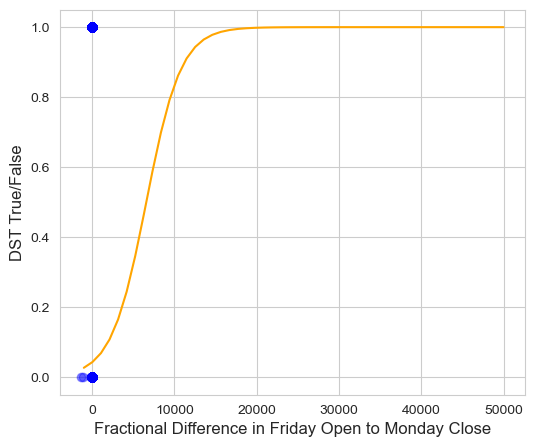

In [50]:
plt.figure(figsize=(6,5))

plt.scatter(health_train['diff_fomc'], health_train['y'],alpha=0.4,color='b')

plt.plot(np.linspace(-1000,50000), log_reg.predict_proba(np.linspace(-1000,50000).reshape(-1,1))[:,1], color = 'orange')

plt.xlabel("Fractional Difference in Friday Open to Monday Close", fontsize=12)
plt.ylabel("DST True/False", fontsize=12)
plt.show()

In [51]:
log_reg=LogisticRegression()

In [52]:
log_reg.fit(health_train[['diff_vol']],health_train['y'])

LogisticRegression()

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


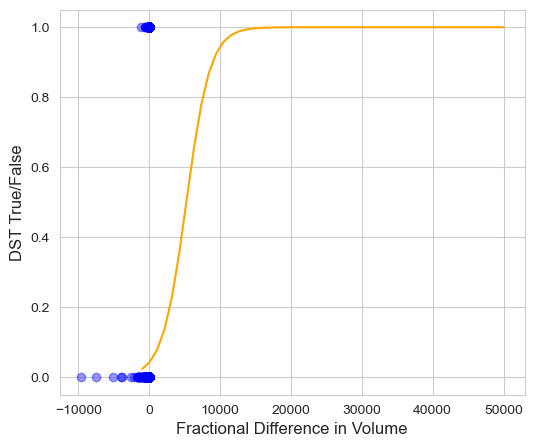

In [53]:
plt.figure(figsize=(6,5))

plt.scatter(health_train['diff_vol'], health_train['y'],alpha=0.4,color='b')

plt.plot(np.linspace(-1000,50000), log_reg.predict_proba(np.linspace(-1000,50000).reshape(-1,1))[:,1], color = 'orange')

plt.xlabel("Fractional Difference in Volume", fontsize=12)
plt.ylabel("DST True/False", fontsize=12)
plt.show()

# $k$ Nearest Neighbors

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [55]:
## Make your  object
n_splits = 5

kfold = KFold(n_splits=n_splits)

In [56]:
## Fill in the range you want to try for k; say from 1 neighbor to 10
ks = range(1,11)

## Make an array to hold the accuracies
k_all_accs = np.zeros((n_splits,len(ks)))

i = 0
for train_index, test_index in kfold.split(health_train):
    ## Get the train and holdout sets
    health_tt = health_train.iloc[train_index]
    health_ho = health_train.iloc[test_index]
    
    ## Loop through the different ks
    j = 0
    for k in ks:
        ## Make the model object
        knn = Pipeline([('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=k))])
        
        ## Fit the model
        knn.fit(health_tt[metrics],health_tt['y'])
        
        ## Make your predictionm
        pred = knn.predict(health_ho[metrics])
        
        ## Record the accuracy on the holdout set
        k_all_accs[i,j] = accuracy_score(health_ho.y.values, pred)
        
        j = j + 1
    i = i + 1

In [57]:
health_train['y'].value_counts(normalize=True)

y
0    0.957699
1    0.042301
Name: proportion, dtype: float64

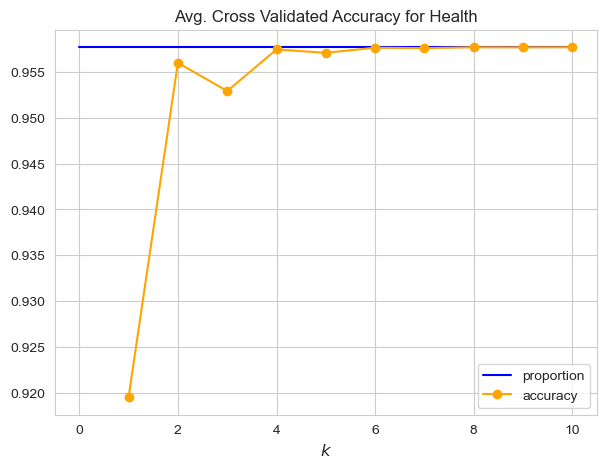

In [68]:
## Plots the accuracies as a function of k
plt.figure(figsize=(7,5))

plt.plot([0,10],[0.957699,0.957699],label='proportion',color='b')

plt.plot(ks, 
         np.mean(k_all_accs, axis=0),
         '-o',color='orange',label='accuracy')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.title("Avg. Cross Validated Accuracy for Health", fontsize=12)

plt.legend()
plt.show()

### Deceision Tree, Random Forest Extra Tree Classification

In [81]:
## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# from sklearn.metrics import accuracy_score
# from tree_helpers import SkNode, traversable_nodes

In [82]:
tree = DecisionTreeClassifier(
    #max_depth = 10, 
    min_samples_leaf = 5, # minimum number of samples in each leaf, to prevent overfitting
    random_state= 216)

rf = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    max_depth = 3, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 2, 
    bootstrap= True, # sampling with replacement
    max_samples = 300, # number of training samples selected with replacement to build tree
    random_state = 216 # for consistency
    )


et = ExtraTreesClassifier(
    n_estimators = 500, 
    #max_depth = 10, 
    min_samples_leaf = 5, 
    max_features = 2, 
    #bootstrap= True, 
    #max_samples = 500, 
    random_state = 216 
    )

In [84]:
metrics=list(metrics)+diffs

In [85]:
metrics

['Friday_open',
 'Monday_open',
 'Friday_close',
 'Monday_close',
 'Friday_adj_close',
 'Monday_adj_close',
 'Friday_low',
 'Monday_low',
 'Friday_high',
 'Monday_high',
 'Friday_volume',
 'Monday_volume',
 'diff_fomc',
 'diff_vol']

In [61]:
## Fit the models
tree.fit(health_train[metrics],health_train['y'])
rf.fit(health_train[metrics],health_train['y'])
et.fit(health_train[metrics],health_train['y'])

ExtraTreesClassifier(max_features=2, min_samples_leaf=5, n_estimators=500,
                     random_state=216)

In [62]:
accs = [accuracy_score(health_test['y'], tree.predict(health_test[metrics])),  accuracy_score(health_test['y'], rf.predict(health_test[metrics])), accuracy_score(health_test['y'], et.predict(health_test[metrics]))]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.941635
rf,0.957685
et,0.957685


In [63]:
health_test['y'].value_counts(normalize=True)

y
0    0.957685
1    0.042315
Name: proportion, dtype: float64

In [66]:
## Fit the models
tree.fit(health_train[diffs],health_train['y'])
rf.fit(health_train[diffs],health_train['y'])
et.fit(health_train[diffs],health_train['y'])

ExtraTreesClassifier(max_features=2, min_samples_leaf=5, n_estimators=500,
                     random_state=216)

In [67]:
accs = [accuracy_score(health_test['y'], tree.predict(health_test[diffs])),  accuracy_score(health_test['y'], rf.predict(health_test[diffs])), accuracy_score(health_test['y'], et.predict(health_test[diffs]))]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.952416
rf,0.957685
et,0.957685


### Balanced Decision Tree, Random Forest, Extra Tree

In [86]:
tree = DecisionTreeClassifier(
    #max_depth = 10, 
    min_samples_leaf = 5, # minimum number of samples in each leaf, to prevent overfitting
    class_weight='balanced')

rf = RandomForestClassifier(
    n_estimators = 500, # number of trees in ensemble
    max_depth = 3, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 2, 
    bootstrap= True, # sampling with replacement
    max_samples = 300, # number of training samples selected with replacement to build tree
    class_weight='balanced'
    )


et = ExtraTreesClassifier(
    n_estimators = 500, 
    #max_depth = 10, 
    min_samples_leaf = 5, 
    max_features = 2, 
    #bootstrap= True, 
    #max_samples = 500, 
    class_weight='balanced'
    )

In [87]:
tree.fit(health_train[metrics],health_train['y'])
rf.fit(health_train[metrics],health_train['y'])
et.fit(health_train[metrics],health_train['y'])

ExtraTreesClassifier(class_weight='balanced', max_features=2,
                     min_samples_leaf=5, n_estimators=500)

In [90]:
tree_preds=tree.predict(health_test[metrics])

confusion_matrix(health_test['y'], tree_preds)

array([[31434,  4189],
       [ 1392,   182]])

In [91]:
rf_preds=rf.predict(health_test[metrics])

confusion_matrix(health_test['y'], rf_preds)

array([[35623,     0],
       [ 1574,     0]])

In [92]:
et_preds=et.predict(health_test[metrics])

confusion_matrix(health_test['y'], et_preds)

array([[34230,  1393],
       [ 1509,    65]])

In [93]:
accs = [accuracy_score(health_test['y'], tree_preds),  accuracy_score(health_test['y'], rf_preds), accuracy_score(health_test['y'], et_preds)]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.849961
rf,0.957685
et,0.921983


In [95]:
prec= [precision_score(health_test['y'], tree_preds),  precision_score(health_test['y'], rf_preds), precision_score(health_test['y'], et_preds)]
pd.DataFrame(prec, index= ['tree', 'rf', 'et'], columns = ['precision'])

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision
tree,0.041638
rf,0.000000
et,0.044582


In [94]:
rec = [recall_score(health_test['y'], tree_preds),  recall_score(health_test['y'], rf_preds), recall_score(health_test['y'], et_preds)]
pd.DataFrame(rec, index= ['tree', 'rf', 'et'], columns = ['recall'])

,recall
tree,0.115629
rf,0.000000
et,0.041296


In [96]:
tree.fit(health_train[diffs],health_train['y'])
rf.fit(health_train[diffs],health_train['y'])
et.fit(health_train[diffs],health_train['y'])

ExtraTreesClassifier(class_weight='balanced', max_features=2,
                     min_samples_leaf=5, n_estimators=500)

In [97]:
tree_preds=tree.predict(health_test[diffs])

confusion_matrix(health_test['y'], tree_preds)

array([[30122,  5501],
       [ 1320,   254]])

In [98]:
rf_preds=rf.predict(health_test[diffs])

confusion_matrix(health_test['y'], rf_preds)

array([[35623,     0],
       [ 1574,     0]])

In [99]:
et_preds=et.predict(health_test[diffs])

confusion_matrix(health_test['y'], et_preds)

array([[32440,  3183],
       [ 1433,   141]])

In [100]:
accs = [accuracy_score(health_test['y'], tree_preds),  accuracy_score(health_test['y'], rf_preds), accuracy_score(health_test['y'], et_preds)]
pd.DataFrame(accs, index= ['tree', 'rf', 'et'], columns = ['accuracy'])

,accuracy
tree,0.816625
rf,0.957685
et,0.875904


In [101]:
prec= [precision_score(health_test['y'], tree_preds),  precision_score(health_test['y'], rf_preds), precision_score(health_test['y'], et_preds)]
pd.DataFrame(prec, index= ['tree', 'rf', 'et'], columns = ['precision'])

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision
tree,0.044136
rf,0.000000
et,0.042419


In [102]:
rec = [recall_score(health_test['y'], tree_preds),  recall_score(health_test['y'], rf_preds), recall_score(health_test['y'], et_preds)]
pd.DataFrame(rec, index= ['tree', 'rf', 'et'], columns = ['recall'])

,recall
tree,0.161372
rf,0.000000
et,0.089581
